Traffic sign classifcation
====================

\#Convolutional Neural Network  
\#LISA dataset  
\#Keras  
\#iOS coreML

In [1]:
import numpy as np
from skimage import io, color, exposure, transform
from sklearn.cross_validation import train_test_split
import os
import glob
import h5py

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_last')

from matplotlib import pyplot as plt
%matplotlib inline

NUM_CLASSES = 14
IMG_SIZE = 32

/home/allenhsu/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Preprocess image  
1. equalize histogram
2. central scrop
3. rescale to 32x32

In [2]:
def preprocess_img(img):
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]

    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    return img


def get_class(img_path):
    return int(img_path.split('$')[1])

## Collect training set
The data was collected from LISA traffic sign data set, we would store the training data into X.h5 file in order to speed up next the process next time.  
http://cvrr.ucsd.edu/LISA/lisa-traffic-sign-dataset.html

In [3]:
try:
    with  h5py.File('X.h5') as hf: 
        X, y = hf['imgs'][:], hf['labels'][:]
    print("Loaded images from X.h5")
    
except (IOError,OSError, KeyError):  
    print("Error in reading X.h5. Processing all images...")
    root_dir = 'training60/'
    imgs = []
    labels = []
    all_img_paths = glob.glob(os.path.join(root_dir, '*.png'))
    np.random.shuffle(all_img_paths)
    for img_path in all_img_paths:
        try:
            img = preprocess_img(io.imread(img_path))
            label = get_class(img_path)
            imgs.append(img)
            labels.append(label)

            if len(imgs)%1000 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
        except (IOError, OSError):
            print('missed', img_path)
            pass

    X = np.array(imgs, dtype='float32')
    y = np.eye(NUM_CLASSES, dtype='uint8')[labels]
    with h5py.File('X.h5','w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=y)

Loaded images from X.h5


## Model architecture
1. 6 convolutional layers with 3 max-pool and drop-out layers  
2. 1 fully-connected layer to collect the features  
3. Collect the result by softmax

In [5]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

model = cnn_model()
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

## Train the model

In [6]:
batch_size = 32
nb_epoch = 30

history = model.fit(X, y,
                  batch_size=batch_size,
                  epochs=nb_epoch,
                  validation_split=0.2,
                  shuffle=True,
                  callbacks=[LearningRateScheduler(lr_schedule),
                            ModelCheckpoint('model.h5',save_best_only=True)])

Train on 2156 samples, validate on 540 samples
Epoch 1/30
2156/2156 [==============================] - 2s 876us/step - loss: 1.2161 - acc: 0.6456 - val_loss: 0.4493 - val_acc: 0.8611
Epoch 2/30
2156/2156 [==============================] - 1s 244us/step - loss: 0.4642 - acc: 0.8595 - val_loss: 0.1966 - val_acc: 0.9463
Epoch 3/30
2156/2156 [==============================] - 1s 251us/step - loss: 0.3242 - acc: 0.8961 - val_loss: 0.1693 - val_acc: 0.9574
Epoch 4/30
2156/2156 [==============================] - 1s 247us/step - loss: 0.2257 - acc: 0.9221 - val_loss: 0.1151 - val_acc: 0.9611
Epoch 5/30
2156/2156 [==============================] - 1s 248us/step - loss: 0.1785 - acc: 0.9392 - val_loss: 0.0953 - val_acc: 0.9704
Epoch 6/30
2156/2156 [==============================] - 1s 246us/step - loss: 0.1611 - acc: 0.9508 - val_loss: 0.1463 - val_acc: 0.9593
Epoch 7/30
2156/2156 [==============================] - 1s 256us/step - loss: 0.1172 - acc: 0.9592 - val_loss: 0.0725 - val_acc: 0.9796
E

In [ ]:
#  "Accuracy"
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
root_dir = 'testing40/'
X_test = []
y_test = []
all_img_paths = glob.glob(os.path.join(root_dir, '*.png'))
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    try:
        img = preprocess_img(io.imread(img_path))
        label = get_class(img_path)
        X_test.append(img)
        y_test.append(label)

    except (IOError, OSError):
        print('missed', img_path)
        pass

X_test = np.array(X_test)
y_test = np.array(y_test)

/home/allenhsu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [13]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.987390350877193


## Train with augmented dataset

Using ImageDataGenerator to augment the training data  
*  Sample-wise standardization  
* Feature-wise standardization  
* ZCA whitening  
* Random rotation, shifts, shear and flips  
* Dimension reordering  


In [9]:
from sklearn.cross_validation import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(featurewise_center=False, 
                             featurewise_std_normalization=False, 
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.,)

datagen.fit(X_train)

In [7]:
model_aug = cnn_model()
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model_aug.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

In [10]:
nb_epoch = 30
history = model_aug.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                    steps_per_epoch=X_train.shape[0],
                                    epochs=nb_epoch,
                                    validation_data=(X_val, y_val),
                                    callbacks=[LearningRateScheduler(lr_schedule),
                                               ModelCheckpoint('model.h5',save_best_only=True)])

Epoch 1/30
2156/2156 [==============================] - 29s 13ms/step - loss: 0.3896 - acc: 0.8747 - val_loss: 0.0305 - val_acc: 0.9852
Epoch 2/30
2156/2156 [==============================] - 29s 14ms/step - loss: 0.1050 - acc: 0.9645 - val_loss: 0.0478 - val_acc: 0.9815
Epoch 3/30
2156/2156 [==============================] - 30s 14ms/step - loss: 0.0643 - acc: 0.9777 - val_loss: 0.0375 - val_acc: 0.9833
Epoch 4/30
2156/2156 [==============================] - 29s 14ms/step - loss: 0.0491 - acc: 0.9837 - val_loss: 0.0286 - val_acc: 0.9889
Epoch 5/30
2156/2156 [==============================] - 29s 14ms/step - loss: 0.0398 - acc: 0.9865 - val_loss: 0.0290 - val_acc: 0.9907
Epoch 6/30
2156/2156 [==============================] - 29s 14ms/step - loss: 0.0313 - acc: 0.9891 - val_loss: 0.0267 - val_acc: 0.9963
Epoch 7/30
2156/2156 [==============================] - 29s 14ms/step - loss: 0.0269 - acc: 0.9910 - val_loss: 0.0349 - val_acc: 0.9944
Epoch 8/30
2156/2156 [==========================

In [14]:
y_pred = model_aug.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.9950657894736842


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1843456   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                3598      
Total para

## Training result with plot and confusion matrix

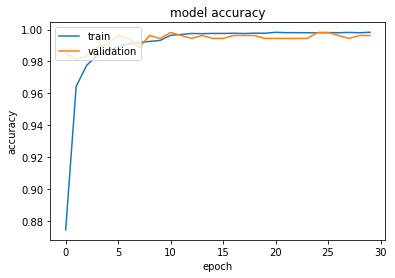

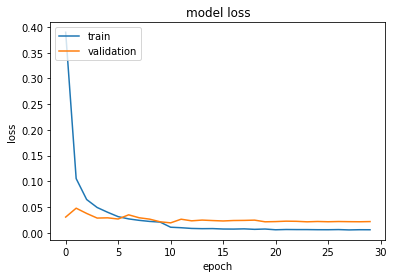

In [16]:
#  "Accuracy"
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('model_accuracy.svg', format='svg', dpi=300)
plt.show()
# "Loss"
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('model_loss.svg', format='svg', dpi=300)
plt.show()

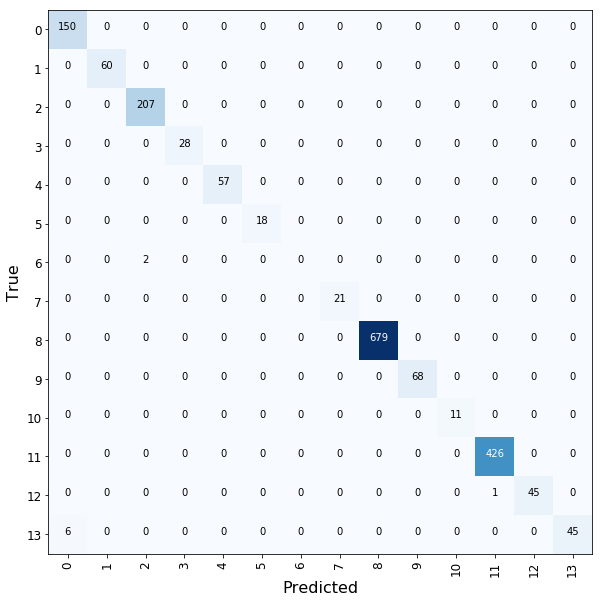

In [17]:
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,10))  
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(NUM_CLASSES)

plt.xticks(range(NUM_CLASSES))
plt.yticks(range(NUM_CLASSES))
plt.xticks(rotation=90)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Predicted', fontsize = 16)
plt.ylabel('True', fontsize= 16)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.savefig('confusion_matrix.svg',  format='svg', dpi=300)
plt.show()


## Save the model and convert the Keras model into coreML for iOS

In [24]:
model_aug.save("traffic_sign_classifier_model.h5")

In [5]:
model_aug = load_model("traffic_sign_classifier_model.h5")

In [6]:
import coremltools
coreml_model = coremltools.converters.keras.convert(model_aug, input_names='image',
                                                    image_input_names='image',
                                                    image_scale=1/255.0,
                                                    class_labels=['speedLimit25', 'speedLimit30', 'speedLimit35', 'speedLimit40', 'speedLimit45', 'speedLimit50', 'speedLimit55', 'speedLimit65', 'stop', 'stopAhead', 'slow', 'pedestrianCrossing', 'school', 'schoolSpeedLimit25'])
#                                                     class_labels=[i for i in range(14)])
coreml_model.save('traffic_sign_classifier_model.mlmodel')

0 : conv2d_21_input, <keras.engine.topology.InputLayer object at 0x7f969e0edb38>
1 : conv2d_21, <keras.layers.convolutional.Conv2D object at 0x7f969e0ed748>
2 : conv2d_21__activation__, <keras.layers.core.Activation object at 0x7f96ae298208>
3 : conv2d_22, <keras.layers.convolutional.Conv2D object at 0x7f969e0edda0>
4 : conv2d_22__activation__, <keras.layers.core.Activation object at 0x7f96ae298470>
5 : max_pooling2d_11, <keras.layers.pooling.MaxPooling2D object at 0x7f969e0edc88>
6 : conv2d_23, <keras.layers.convolutional.Conv2D object at 0x7f969e09f400>
7 : conv2d_23__activation__, <keras.layers.core.Activation object at 0x7f96ae2984e0>
8 : conv2d_24, <keras.layers.convolutional.Conv2D object at 0x7f969e08e4a8>
9 : conv2d_24__activation__, <keras.layers.core.Activation object at 0x7f96ae2983c8>
10 : max_pooling2d_12, <keras.layers.pooling.MaxPooling2D object at 0x7f969e0bcb00>
11 : conv2d_25, <keras.layers.convolutional.Conv2D object at 0x7f969e05cf98>
12 : conv2d_25__activation__, <